# Example 7

[HURDAT2](https://www.nhc.noaa.gov/data/) is a hurricane dataset provided by The
National Hurricane Center and Central Pacific Hurricane Center. It contains the
location data of hurricanes from 1851 to 2022.

This example shows how to use yupi for inspecting and processing a dataset of
two-dimensional trajectories using HURDAT2 as an example.


## 1. Import dependencies

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np

from yupi import Trajectory
from yupi.core import JSONSerializer
from yupi.graphics import plot_2d

## 2. Define global variables and helper functions

In [2]:
COLORS = ["#88ff88", "#ffee66", "#ffbb33", "#ff8844", "#bb1111"]
CATEGORIES = list(range(1, 6))

def boxplot_style(cat):
    return dict(
        positions=[cat],
        patch_artist=True,
        widths=0.6,
        boxprops=dict(facecolor=COLORS[cat - 1]),
        medianprops=dict(color="black", linewidth=2)
    )

## 3. Load dataset

In [3]:
with open("resources/data/hurdat2.json", "r", encoding="utf-8") as data_fd:
    data = json.load(data_fd)
    hurricanes = {cat: [] for cat in CATEGORIES}
    for cat, traj in zip(data["labels"], data["trajs"]):
        if cat > 0:
            hurricanes[cat].append(JSONSerializer.from_json(traj))

## 4. Plot all the trajectories

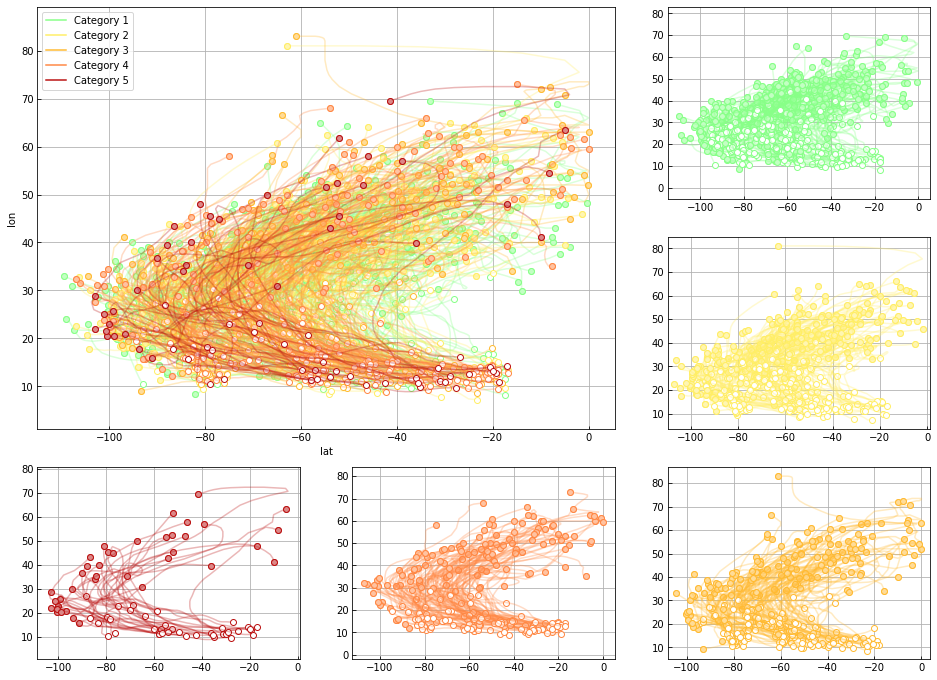

In [4]:
plt.figure(figsize=(16, 12))
gs = plt.GridSpec(3, 3)
subplots = [gs[:2,:2], gs[0, 2], gs[1, 2], gs[2, 2], gs[2, 1], gs[2, 0]]
for cat, hurrs in hurricanes.items():
    plt.subplot(subplots[0]) # Main subplot
    main_ax = plot_2d(hurrs, legend=False, color=COLORS[cat - 1], alpha=0.3, show=False)
    main_ax.update({"xlabel": "lat", "ylabel": "lon"})

    plt.subplot(subplots[cat]) # Category subplot
    ax = plot_2d(hurrs, legend=False, color=COLORS[cat - 1], alpha=0.3, show=False)
    ax.update({"xlabel": "", "ylabel": ""})

main_ax.legend(handles=[
    plt.plot([], [], color=color, label=f"Category {cat}")[0]
    for color, cat in zip(COLORS, CATEGORIES)
])
plt.show()

## 5. Data distribution

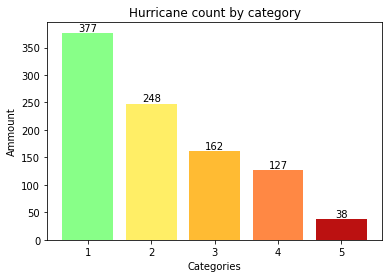

In [5]:
counts = list(map(len, hurricanes.values()))

_, ax = plt.subplots()
bars = ax.bar(CATEGORIES, counts, color=COLORS)
plt.bar_label(bars)
plt.xlabel("Categories")
plt.ylabel("Ammount")
plt.title("Hurricane count by category")
plt.show()

## 6. Duration analysis

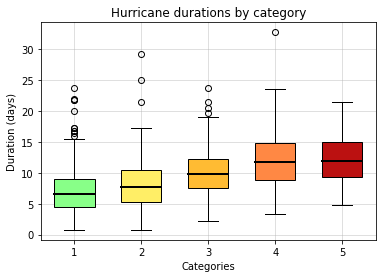

In [6]:
for cat, hurrs in hurricanes.items():
    durations = [(traj.t[-1] - traj.t[0]) / (3600 * 24) for traj in hurrs]
    plt.boxplot(durations, **boxplot_style(cat))

plt.xlabel("Categories")
plt.ylabel("Duration (days)")
plt.title("Hurricane durations by category")
plt.grid(alpha=0.5)
plt.show()

## 7. Initial latitudes analysis

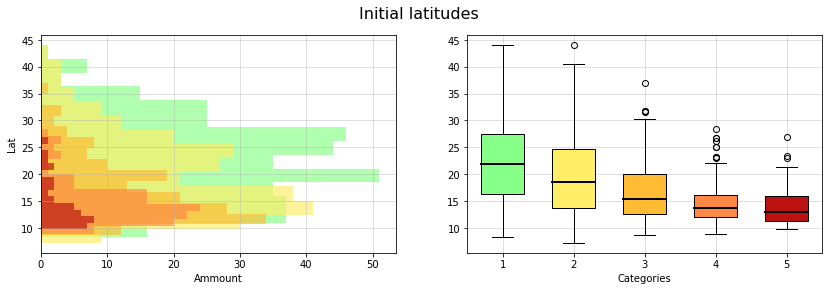

In [9]:
init_lats_by_cat = []

plt.figure(figsize=(14, 4))
plt.suptitle('Initial latitudes', fontsize=16)

plt.subplot(1, 2, 1)
for cat, hurrs in hurricanes.items():
    init_lats_by_cat.append([traj.r.y[0] for traj in hurrs])
    plt.hist(init_lats_by_cat[-1], bins=14, color=COLORS[cat - 1] + "aa",orientation="horizontal")
plt.xlabel("Ammount")
plt.ylabel("Lat")
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
for i, init_lats in enumerate(init_lats_by_cat):
    plt.boxplot(init_lats, **boxplot_style(i + 1))
plt.xlabel("Categories")
plt.grid(alpha=0.5)
plt.show()